In [1]:
import json
from pathlib import Path
from collections import Counter
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tensorboard.backend.event_processing import event_accumulator
from plotnine import *
from sklearn.cluster import AgglomerativeClustering
import magicsoup as ms
import e1_co2_fixing.src.util as util

theme_set(theme_minimal())
THIS_DIR = Path(".") / "e1_co2_fixing"
RUNS_DIR = THIS_DIR / "runs"

world = ms.World.from_file(rundir=RUNS_DIR)

In [2]:
records = []
for rundir in RUNS_DIR.glob("2023-07-*"):
    with open(rundir / "hparams.json", "r") as fh:
        data = json.load(fh)
    records.append({"name": rundir.name, **data})
hparams = pd.DataFrame.from_records(records)

hparams.loc[:, "trial"] = "n" + hparams["name"].str.rsplit("_", n=1).str[1]
hparams.loc[:, "purpose"] = "train-pathway"
hparams.loc[hparams["pathway-label"].isna(), "purpose"] = "validate-cells"
hparams.loc[hparams["pathway-label"].isna() & hparams["init-label"].isna(), "purpose"] = "init-cells"
hparams.loc[:, "culture"] = "batch"
hparams.loc[hparams["purpose"] == "validate-cells", "culture"] = "chemostat"

# TODO: network chart?
hparams = hparams.sort_values("name").reset_index()
hparams[["name", "trial", "pathway-label", "init-label", "purpose", "culture"]]

,name,trial,pathway-label,init-label,purpose,culture
0,2023-07-22_11-51_0,n0,NaN,NaN,init-cells,batch
1,2023-07-22_11-56_0,n0,WL-0,2023-07-22_11-51_0:-1,train-pathway,batch
2,2023-07-22_11-56_1,n1,WL-0,2023-07-22_11-51_0:-1,train-pathway,batch
3,2023-07-22_12-19_0,n0,WL-1,2023-07-22_11-56_0:-1,train-pathway,batch
4,2023-07-22_12-19_1,n1,WL-1,2023-07-22_11-56_0:-1,train-pathway,batch
5,2023-07-22_12-44_0,n0,WL-2,2023-07-22_12-19_0:-1,train-pathway,batch
6,2023-07-22_12-44_1,n1,WL-2,2023-07-22_12-19_0:-1,train-pathway,batch
7,2023-07-22_14-14_0,n0,WL-3,2023-07-22_12-44_0:-1,train-pathway,batch
8,2023-07-22_14-14_1,n1,WL-3,2023-07-22_12-44_0:-1,train-pathway,batch
9,2023-07-23_13-37_0,n0,WL-4,2023-07-22_14-14_0:-1,train-pathway,batch


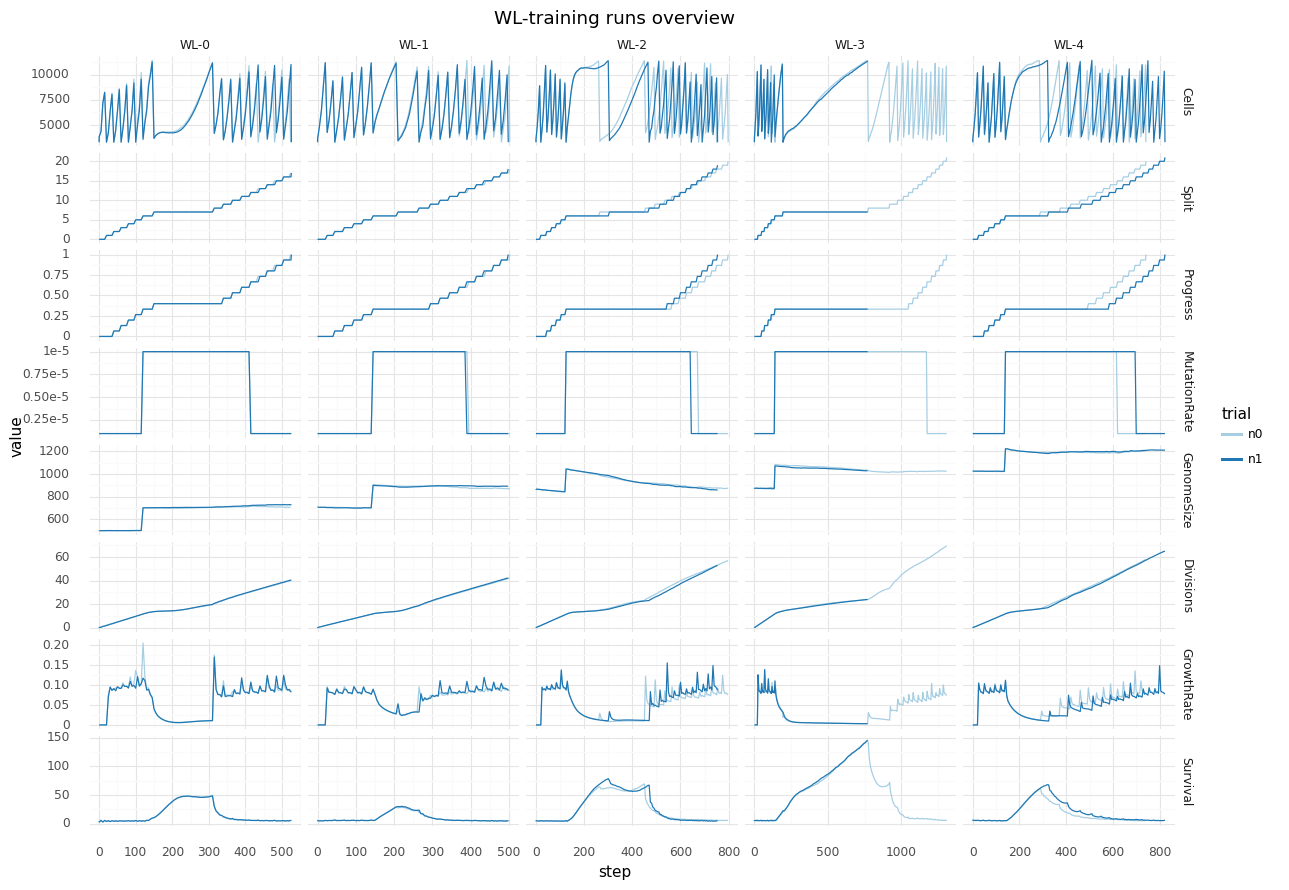

<ggplot: (8766910039086)>

In [47]:
scalars = [
    ("Cells/Total", "Cells"),
    ("Other/Split", "Split"),
    ("Other/Progress", "Progress"),
    ("Other/MutationRate", "MutationRate"),
    ("Cells/GenomeSize", "GenomeSize"),
    ("Cells/Divisions", "Divisions"),
    ("Cells/GrowthRate", "GrowthRate"),
    ("Cells/Survival", "Survival")
]

records = []
for _, row in hparams.loc[hparams["purpose"] == "train-pathway"].iterrows():
    event_dir = RUNS_DIR / row["name"]
    tf_ea = event_accumulator.EventAccumulator(str(event_dir))
    tf_ea.Reload()
    for scalar, variable in scalars:
        for obj in tf_ea.Scalars(scalar):
            records.append({
                "name": row["name"],
                "variable": variable,
                "value": obj.value,
                "step": obj.step,
                "pathway-label": row["pathway-label"],
                "trial": row["trial"]
            })

df = pd.DataFrame.from_records(records)
df["variable"] = pd.Categorical(df["variable"], categories=[d[1] for d in scalars])

(ggplot(df)
    + geom_line(aes(y="value", x="step", group="name", color="trial"))
    + facet_grid("variable ~ pathway-label", scales="free")
    + scale_color_brewer(type="Qualitative", palette="Paired")
    + ggtitle("WL-training runs overview")
    + theme(figure_size=(14, 10)))

In [9]:
from mizani import palettes
palettes.brewer_helper._ncolor_range["Qualitative"].keys()

dict_keys(['Accent', 'Dark2', 'Paired', 'Pastel1', 'Pastel2', 'Set1', 'Set2', 'Set3'])

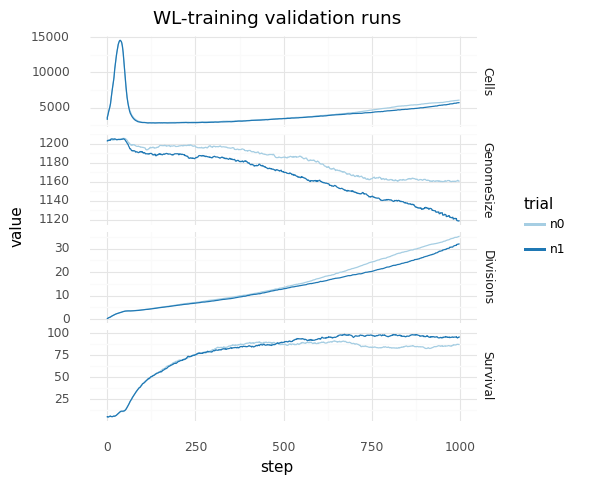

<ggplot: (8766903267295)>

In [51]:
scalars = [
    ("Cells/Total", "Cells"),
    ("Cells/GenomeSize", "GenomeSize"),
    ("Cells/Divisions", "Divisions"),
    ("Cells/Survival", "Survival")
]

records = []
for _, row in hparams.loc[hparams["purpose"] == "validate-cells"].iterrows():
    event_dir = RUNS_DIR / row["name"]
    tf_ea = event_accumulator.EventAccumulator(str(event_dir))
    tf_ea.Reload()
    for scalar, variable in scalars:
        for obj in tf_ea.Scalars(scalar):
            records.append({
                "name": row["name"],
                "variable": variable,
                "value": obj.value,
                "step": obj.step,
                "trial": row["trial"]
            })

df = pd.DataFrame.from_records(records)
df["variable"] = pd.Categorical(df["variable"], categories=[d[1] for d in scalars])

(ggplot(df)
    + geom_line(aes(y="value", x="step", group="name", color="trial"))
    + facet_grid("variable ~ .", scales="free")
    + scale_color_brewer(type="Qualitative", palette="Paired")
    + ggtitle("WL-training validation runs")
    + theme(figure_size=(5, 5)))

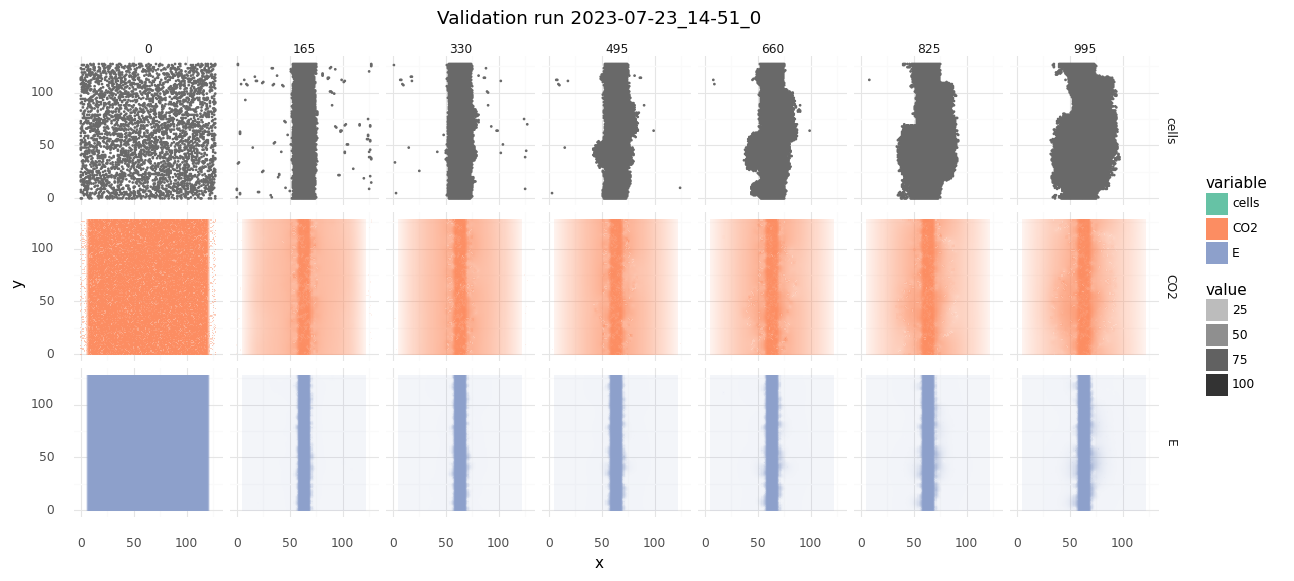

<ggplot: (8766902255484)>

In [67]:
n = 6
name = "2023-07-23_14-51_0"
molecules = ["CO2", "E"]

i = world.chemistry.molname_2_idx["CO"]
xs, ys = (world.molecule_map[i] > 0.0).argwhere().T.tolist()
vals = world.molecule_map[i, xs, ys].tolist()
for x, y, d in zip(xs, ys, vals):
    records.append({"x": x, "y": y, "CO": d})


records = []
for _, row in hparams.loc[hparams["name"] == name].iterrows():
    rundir = RUNS_DIR / row["name"]
    steps = util.find_steps(rundir=rundir)
    
    d, r = divmod(len(steps), n)
    sample_steps = [steps[i * d] for i in range(n)]
    if r > 0:
        sample_steps.append(steps[-1])
    
    for step in sample_steps:
        world.load_state(statedir=rundir / f"step={step}", ignore_cell_params=True)
        
        xs = world.cell_positions[:, 0].tolist()
        ys = world.cell_positions[:, 1].tolist()
        for x, y in zip(xs, ys):
            records.append({
                "x": x,
                "y": y,
                "step": step,
                "variable": "cells"
            })

        for molname in molecules:
            mi = world.chemistry.molname_2_idx[molname]
            xs, ys = (world.molecule_map[mi] > 0.0).argwhere().T.tolist()
            vals = world.molecule_map[mi, xs, ys].tolist()
            for x, y, d in zip(xs, ys, vals):
                records.append({
                    "x": x,
                    "y": y,
                    "step": step,
                    "value": d,
                    "variable": molname
                })

df = pd.DataFrame.from_records(records)
df["variable"] = pd.Categorical(df["variable"], categories=["cells"] + molecules)

axis_lims = (0, world.map_size)
(ggplot(df)
    + geom_point(aes(y="y", x="x"), size=0.1, color="dimgray", data=df[df["variable"] == "cells"])
    + geom_tile(aes(y="y", x="x", alpha="value", fill="variable"), data=df[df["variable"] != "cells"])
    + coord_fixed(ratio=1, xlim=axis_lims, ylim=axis_lims)
    + scale_fill_brewer(type="Qualitative", palette="Set2")
    + facet_grid("variable ~ step")
    + ggtitle(f"Validation run {name}")
    + theme(figure_size=(14, 9)))

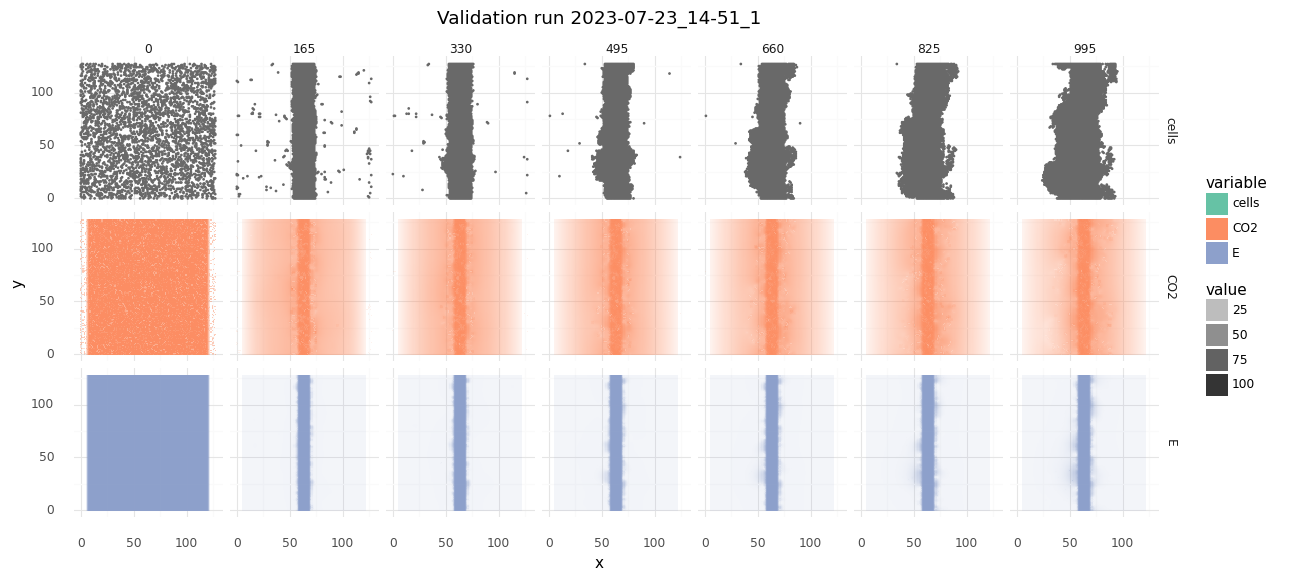

<ggplot: (8766902250935)>

In [68]:
n = 6
name = "2023-07-23_14-51_1"
molecules = ["CO2", "E"]

i = world.chemistry.molname_2_idx["CO"]
xs, ys = (world.molecule_map[i] > 0.0).argwhere().T.tolist()
vals = world.molecule_map[i, xs, ys].tolist()
for x, y, d in zip(xs, ys, vals):
    records.append({"x": x, "y": y, "CO": d})


records = []
for _, row in hparams.loc[hparams["name"] == name].iterrows():
    rundir = RUNS_DIR / row["name"]
    steps = util.find_steps(rundir=rundir)
    
    d, r = divmod(len(steps), n)
    sample_steps = [steps[i * d] for i in range(n)]
    if r > 0:
        sample_steps.append(steps[-1])
    
    for step in sample_steps:
        world.load_state(statedir=rundir / f"step={step}", ignore_cell_params=True)
        
        xs = world.cell_positions[:, 0].tolist()
        ys = world.cell_positions[:, 1].tolist()
        for x, y in zip(xs, ys):
            records.append({
                "x": x,
                "y": y,
                "step": step,
                "variable": "cells"
            })

        for molname in molecules:
            mi = world.chemistry.molname_2_idx[molname]
            xs, ys = (world.molecule_map[mi] > 0.0).argwhere().T.tolist()
            vals = world.molecule_map[mi, xs, ys].tolist()
            for x, y, d in zip(xs, ys, vals):
                records.append({
                    "x": x,
                    "y": y,
                    "step": step,
                    "value": d,
                    "variable": molname
                })

df = pd.DataFrame.from_records(records)
df["variable"] = pd.Categorical(df["variable"], categories=["cells"] + molecules)

axis_lims = (0, world.map_size)
(ggplot(df)
    + geom_point(aes(y="y", x="x"), size=0.1, color="dimgray", data=df[df["variable"] == "cells"])
    + geom_tile(aes(y="y", x="x", alpha="value", fill="variable"), data=df[df["variable"] != "cells"])
    + coord_fixed(ratio=1, xlim=axis_lims, ylim=axis_lims)
    + scale_fill_brewer(type="Qualitative", palette="Set2")
    + facet_grid("variable ~ step")
    + ggtitle(f"Validation run {name}")
    + theme(figure_size=(14, 9)))

In [23]:
name = "2023-07-23_14-51_1/step=995"

def summarize_proteomes(world: ms.World) -> list[list[str]]:
    out = []
    for cell_i in range(world.n_cells):
        cell = world.get_cell(by_idx=cell_i)
        out.append([str(d) for d in cell.proteome])
    return out

world.load_state(statedir=RUNS_DIR / name, batch_size=1000)
all_cell_prots = summarize_proteomes(world=world)

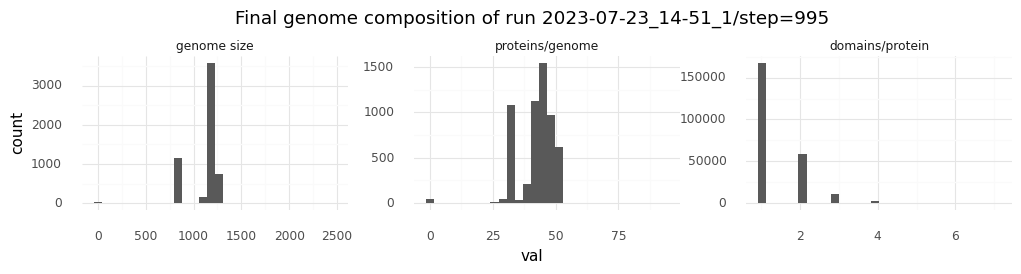

<ggplot: (8775039311143)>

In [24]:
def get_genome_composition(proteomes: list[list[str]], genomes: list[str]):
    out = []
    for cell_i, (prots, genome) in enumerate(zip(proteomes, genomes)):
        prots = [d for d in prots if len(d) > 0]
        out.append({"cell": cell_i, "var": "genome size", "val": len(genome)})
        out.append({"cell": cell_i, "var": "proteins/genome", "val": len(prots)})
        if len(prots) > 0:
            for prot in prots:
                n = 0 if len(prot) == 0 else len(prot.split("|"))
                out.append({"cell": cell_i, "var": "domains/protein", "val": n})
    return out

records = get_genome_composition(proteomes=all_cell_prots, genomes=world.genomes)
df = pd.DataFrame.from_records(records)
df["var"] = pd.Categorical(df["var"], categories=["genome size", "proteins/genome", "domains/protein"])

(ggplot(df)
    + geom_histogram(aes(x="val"), bins=30)
    + facet_wrap("var", scales="free", ncol=3)
    + ggtitle(f"Final genome composition of run {name}")
    + theme(figure_size=(12, 2), subplots_adjust={'wspace': 0.25}))

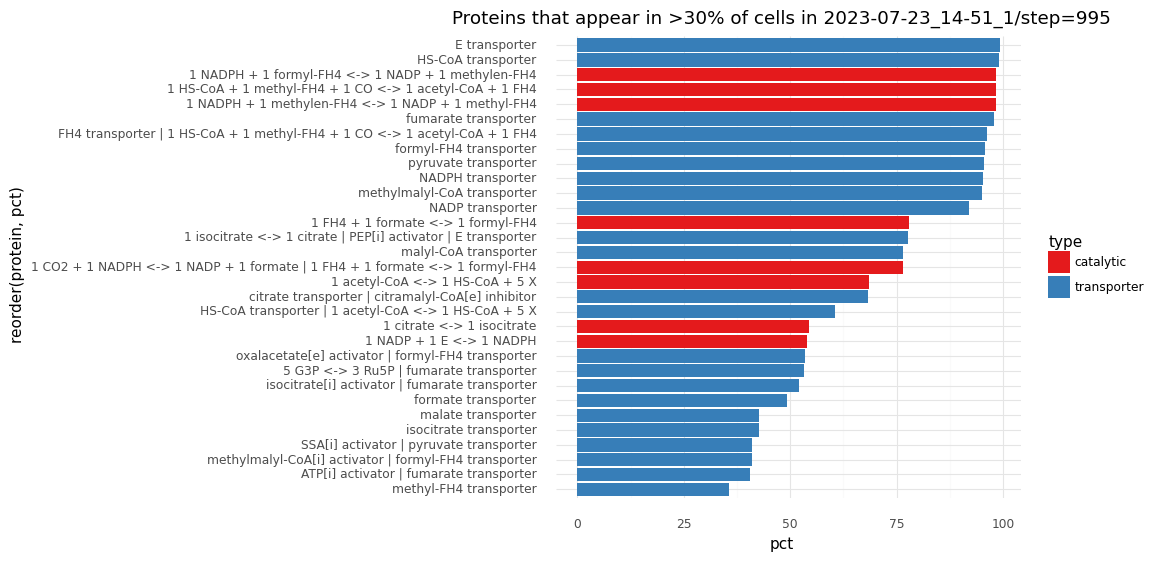

<ggplot: (8775039125538)>

In [25]:
def count_unique_proteins(proteomes: list[list[str]]) -> dict[str, int]:
    out = {}
    for prots in proteomes:
        for prot in set(prots):
            if prot not in out:
                out[prot] = 0
            out[prot] += 1
    return out

prot_cnts = count_unique_proteins(proteomes=all_cell_prots)
df = pd.DataFrame.from_records([{"protein": k, "n": d} for k, d in prot_cnts.items()])
df["pct"] = df["n"] / len(all_cell_prots) * 100
df = df.loc[df["protein"] != ""]
df.loc[:, "type"] = "catalytic"
df.loc[df["protein"].str.contains("transporter"), "type"] = "transporter"
df.sort_values("pct", ascending=False, inplace=True)

(ggplot(df.loc[df["pct"] > 30])
    + geom_col(aes(y="pct", x="reorder(protein, pct)", fill="type"))
    + coord_flip()
    + scale_fill_brewer(type="Qualitative", palette="Set1")
    + ggtitle(f"Proteins that appear in >30% of cells in {name}")
    + theme(figure_size=(6, 6)))

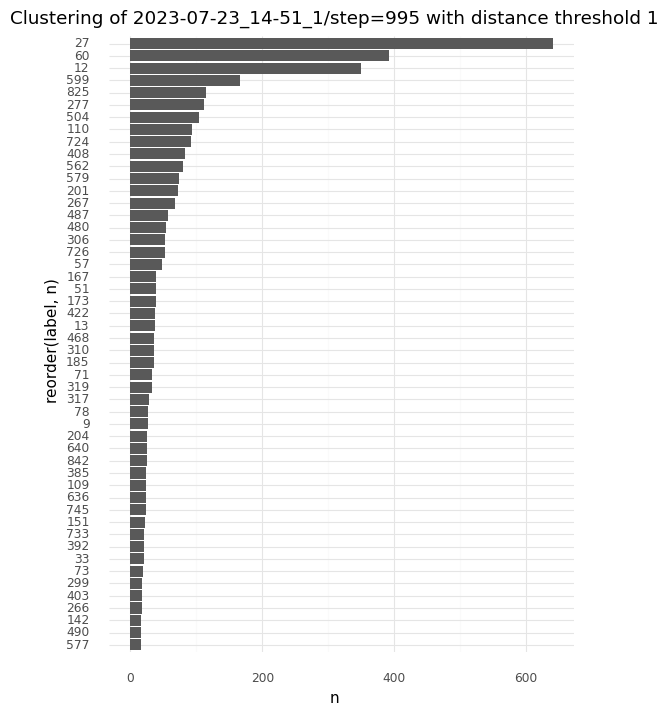

<ggplot: (8774965161015)>

In [46]:
# X = np.zeros((len(all_cell_prots), len(prot_cnts)))
# for pi, prot in enumerate(prot_cnts):
#     for ci, proteome in enumerate(all_cell_prots):
#         if prot in proteome:
#             X[ci, pi] = 1

rgt = (world.kinetics.N[:world.n_cells] > 0).sum(dim=1).numpy()
lft = (world.kinetics.N[:world.n_cells] < 0).sum(dim=1).numpy()
X = np.concatenate([rgt, lft], axis=1)

dthresh = 1
#model = AgglomerativeClustering(n_clusters=None, linkage="complete", metric="manhattan", distance_threshold=dthresh)
model = AgglomerativeClustering(n_clusters=None, linkage="ward", distance_threshold=dthresh)
clustering = model.fit(X)

label_cnts = Counter(clustering.labels_)

df = pd.DataFrame.from_records([{"label": k, "n": d} for k, d in label_cnts.items()])
df.sort_values("n", ascending=False, inplace=True)

(ggplot(df.iloc[:50])
    + geom_col(aes(x="reorder(label, n)", y="n"))
    + coord_flip()
    + ggtitle(f"Clustering of {name} with distance threshold {dthresh}")
    + theme(figure_size=(6, 8)))

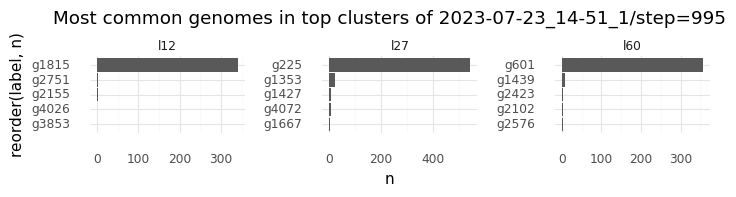

<ggplot: (8775001428818)>

In [58]:
def get_common_genomes(genomes: list, cluster: int, labels: list, top_n: int) -> pd.DataFrame:
    cell_idxs = [i for i, d in enumerate(labels) if d == cluster]
    genome_cnts = Counter([genomes[d] for d in cell_idxs])
    records = [
        {"label": f"g{genomes.index(k)}", "n": d, "cluster": f"l{cluster}"}
        for k, d in genome_cnts.items()
    ]
    return pd.DataFrame.from_records(records).sort_values("n", ascending=False).iloc[:top_n]

top_clusters = [d for d, _ in label_cnts.most_common(n=3)]
df = pd.concat([
    get_common_genomes(genomes=world.genomes, cluster=d, labels=clustering.labels_, top_n=5)
    for d in top_clusters
]).reset_index()
top_labels = df.loc[df.groupby("cluster")["n"].idxmax(), "label"]

(ggplot(df)
    + geom_col(aes(x="reorder(label, n)", y="n"))
    + facet_wrap("cluster", ncol=3, scales="free")
    + coord_flip()
    + ggtitle(f"Most common genomes in top clusters of {name}")
    + theme(figure_size=(8, 1), subplots_adjust={'wspace': 0.5}))

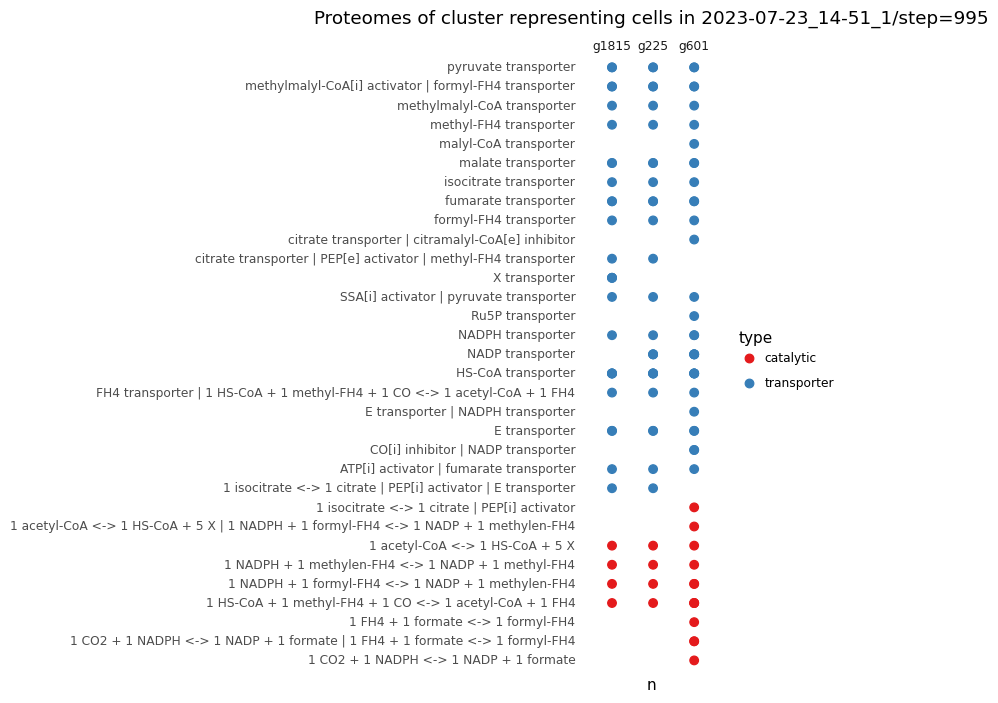

<ggplot: (8774963610342)>

In [61]:
def get_proteomes_summary(world: ms.World, labels: list[str]):
    out = []
    for label in labels:
        cell = world.get_cell(by_idx=int(label[1:]))
        strs = [str(d) for d in cell.proteome if str(d) != ""]
        out.extend([{"protein": d, "n": 1, "label": label} for d in strs])
    return  pd.DataFrame.from_records(out)

df = get_proteomes_summary(world=world, labels=top_labels.tolist())
df.loc[:, "type"] = "catalytic"
df.loc[df["protein"].str.contains("transporter"), "type"] = "transporter"

(ggplot(df)
    + geom_point(aes(x="protein", y="n", color="type"), size=3)
    + coord_flip()
    + facet_grid(". ~ label")
    + scale_color_brewer(type="Qualitative", palette="Set1")
    + ggtitle(f"Proteomes of cluster representing cells in {name}")
    + theme(figure_size=(1.5, 8))
    + theme(axis_title_y=element_blank(), axis_text_x=element_blank())
    + theme(panel_grid_major=element_blank(), panel_grid_minor=element_blank()))

In [ ]:
# TODO: muss erst kinetics tensoren fixen...
# top_labels könnte besser aussehen
world.kinetics.N[]

In [66]:
molnames = [d.name for d in world.chemistry.molecules]

records = []
for step in range(100):
    world.enzymatic_activity()
    world.diffuse_molecules()
    for label in top_labels.tolist():
        genome = world.genomes[int(label[1:])]
        cell_idxs = [i for i, d in enumerate(world.genomes) if d == genome]
        for ci in cell_idxs:
            pos = world.cell_positions[ci]
            int_molecules = world.cell_molecules[ci, :]
            ext_molecules = world.molecule_map[:, pos[0], pos[1]]
            for mi, name in enumerate(molnames):
                records.append({"step": step, "label": label, "cell": ci, "mol": f"{name}[i]", "x": int_molecules[mi].item()})
                records.append({"step": step, "label": label, "cell": ci, "mol": f"{name}[e]", "x": ext_molecules[mi].item()})
df = pd.DataFrame.from_records(records)

RuntimeError: einsum(): subscript c has size 5702 for operand 1 which does not broadcast with previously seen size 11404

Found 3 clusters


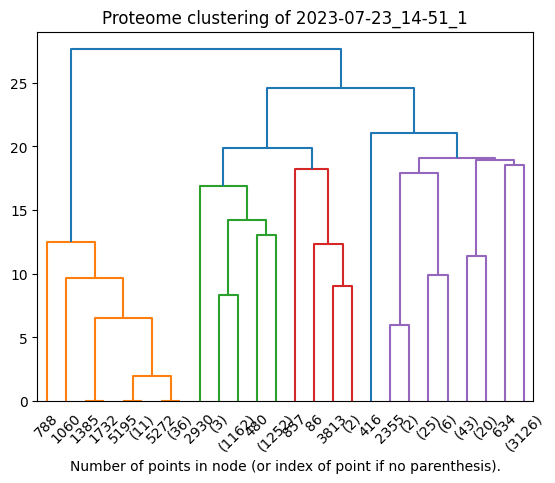

In [76]:
# TODO: watch this cell's internal and external concentrations for a few rounds

In [74]:
clustering.labels_.max()

1

In [9]:
def dom_in_prot(dom: str, prot: str) -> bool:
    if " <-> " not in dom:
        return dom in prot
    lft, rgt = dom.split(" <-> ")
    fwd = lft + " <-> " + rgt
    bwd = rgt + " <-> " + lft
    return fwd in prot or bwd in prot

def dom_in_proteome(dom: str, prots: list[str]) -> bool:
    return any(dom_in_prot(dom=dom, prot=d) for d in prots)

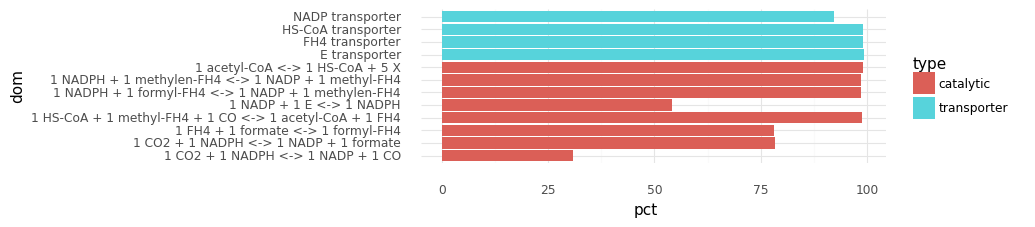

<ggplot: (8762236395830)>

In [32]:
expected_doms = [
    "E transporter",
    "NADP transporter",
    "HS-CoA transporter",
    "FH4 transporter",
    "1 NADP + 1 E <-> 1 NADPH",
    "1 CO2 + 1 NADPH <-> 1 NADP + 1 CO",
    "1 CO2 + 1 NADPH <-> 1 NADP + 1 formate",
    "1 FH4 + 1 formate <-> 1 formyl-FH4",
    "1 NADPH + 1 methylen-FH4 <-> 1 NADP + 1 methyl-FH4",
    "1 NADPH + 1 formyl-FH4 <-> 1 NADP + 1 methylen-FH4",
    "1 HS-CoA + 1 methyl-FH4 + 1 CO <-> 1 acetyl-CoA + 1 FH4",
    "1 acetyl-CoA <-> 1 HS-CoA + 5 X",
]

dom_cnts = {d: 0 for d in expected_doms}
for prots in all_cell_prots:
    for dom in expected_doms:
        if dom_in_proteome(dom=dom, prots=prots):
            dom_cnts[dom] += 1

n = len(all_cell_prots)
df = pd.DataFrame.from_records([{"dom": k, "pct": d / n * 100} for k, d in dom_cnts.items()])
df.loc[:, "type"] = "transporter"
df.loc[["<->" in d for d in df["dom"]], "type"] = "catalytic"
df["type"] = pd.Categorical(df["type"], categories=["catalytic", "transporter"])

(ggplot(df)
    + geom_col(aes(y="pct", x="dom", fill="type"))
    + coord_flip()
    + scale_fill_brewer(type="Qualitative", palette="Set2")
    + theme(figure_size=(6, 2)))

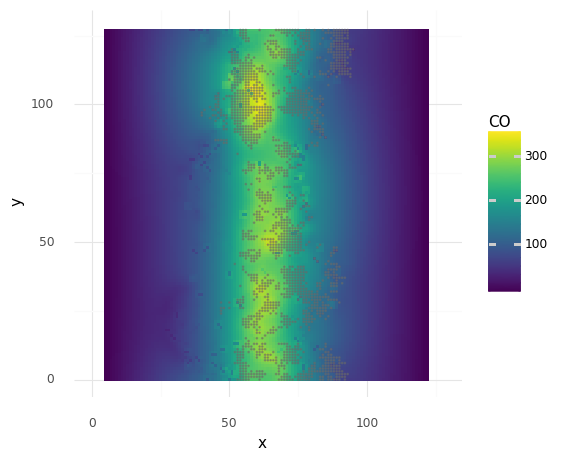

<ggplot: (8762130894812)>

In [33]:
records = []
i = world.chemistry.molname_2_idx["CO"]
xs, ys = (world.molecule_map[i] > 0.0).argwhere().T.tolist()
vals = world.molecule_map[i, xs, ys].tolist()
for x, y, d in zip(xs, ys, vals):
    records.append({"x": x, "y": y, "CO": d})

mols_df = pd.DataFrame.from_records(records)

has_co = [dom_in_proteome("1 CO2 + 1 NADPH <-> 1 NADP + 1 CO", d) for d in all_cell_prots]
cells_df = pd.DataFrame(world.cell_positions[has_co].tolist(), columns=["x", "y"])

limits = (0, world.map_size)
(ggplot(mols_df)
    + geom_tile(aes(y="y", x="x", fill="CO"))
    + geom_point(aes(y="y", x="x"), color="dimgray", alpha=0.5, size=0.1, data=cells_df)
    + coord_fixed(ratio=1, xlim=limits, ylim=limits)
    + theme(figure_size=(5, 4)))

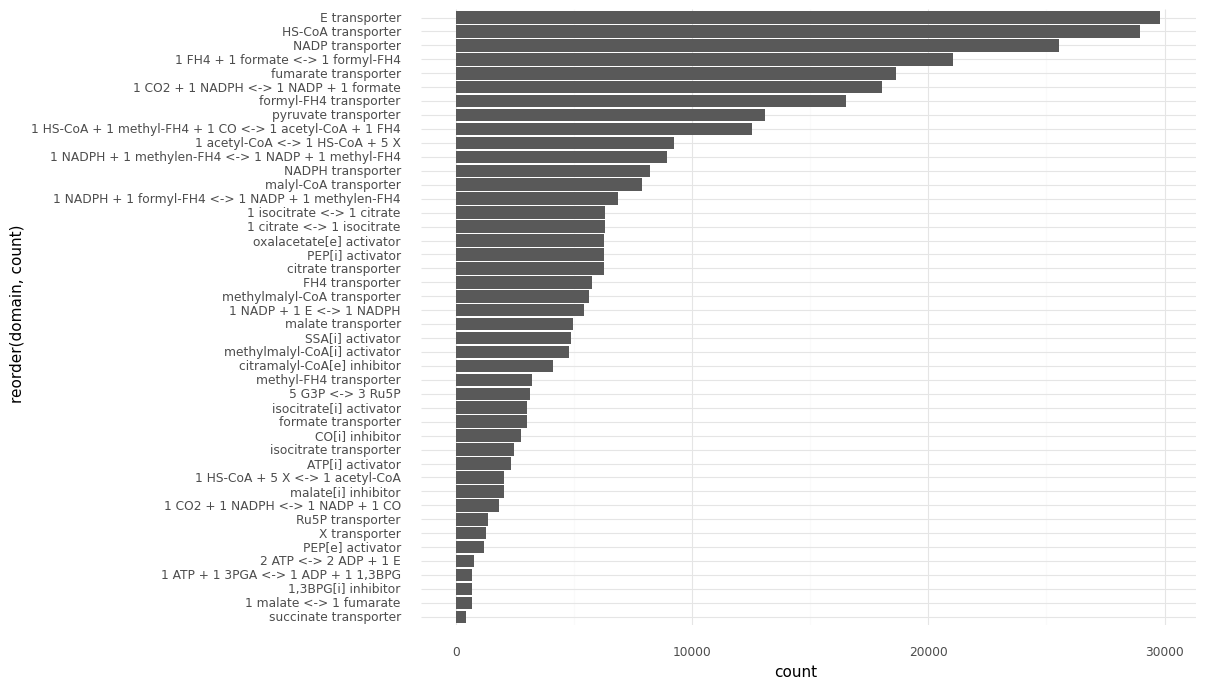

<ggplot: (8762162511737)>

In [57]:
dom_counts = {}
for prots in all_cell_prots:
    for prot in prots:
        if len(prot) > 0:
            for dom in prot.split(" | "):
                if dom in dom_counts:
                   dom_counts[dom] += 1
                else:
                   dom_counts[dom] = 0

df = pd.DataFrame([[k, d] for k, d in dom_counts.items()], columns=["domain", "count"])
df["pct"] = df["count"] / df["count"].sum()

(ggplot(df.loc[df["pct"] > 0.001])
    + geom_col(aes(y="count", x="reorder(domain, count)"))
    + coord_flip()
    + theme(figure_size=(10, 8)))

In [45]:
# TODO: set enrichment analysis
#       which set of domains exists more commonly than random
#       hopefully WL and other related domains
#       domains must be normalized
# würde mit Apriori algorithm gehen
# 1. Assoziationsregeln: domain A kommt häufig zusammen mit Domain B
# 2. Biggest subset: Iterativ set vergrößern, welche domains kommen häufig vor

{'HS-CoA transporter': 28970,
 '1 NADP + 1 formate <-> 1 CO2 + 1 NADPH': 21,
 'FH4 transporter': 5764,
 '1 HS-CoA + 1 methyl-FH4 + 1 CO <-> 1 acetyl-CoA + 1 FH4': 12534,
 'NADPH transporter': 8205,
 'NADP transporter': 25521,
 '1 CO2 + 1 NADPH <-> 1 NADP + 1 CO': 1812,
 '1 isocitrate <-> 1 citrate': 6316,
 'PEP[i] activator': 6270,
 'E transporter': 29819,
 '1 NADPH + 1 formyl-FH4 <-> 1 NADP + 1 methylen-FH4': 6864,
 '1 NADPH + 1 methylen-FH4 <-> 1 NADP + 1 methyl-FH4': 8949,
 'malate[i] inhibitor': 2025,
 'malyl-CoA transporter': 7901,
 'citrate transporter': 6266,
 'citramalyl-CoA[e] inhibitor': 4114,
 'formate transporter': 3017,
 'oxalacetate[e] activator': 6278,
 'formyl-FH4 transporter': 16516,
 '1 CO2 + 1 NADPH <-> 1 NADP + 1 formate': 18054,
 '1 NADP + 1 succinate <-> 1 NADPH + 1 fumarate': 36,
 '1 NADP + 1 E <-> 1 NADPH': 5414,
 '1 HS-CoA + 5 X <-> 1 acetyl-CoA': 2054,
 'fumarate transporter': 18644,
 'SSA[i] activator': 4869,
 'methylmalyl-CoA transporter': 5655,
 'isocitrate

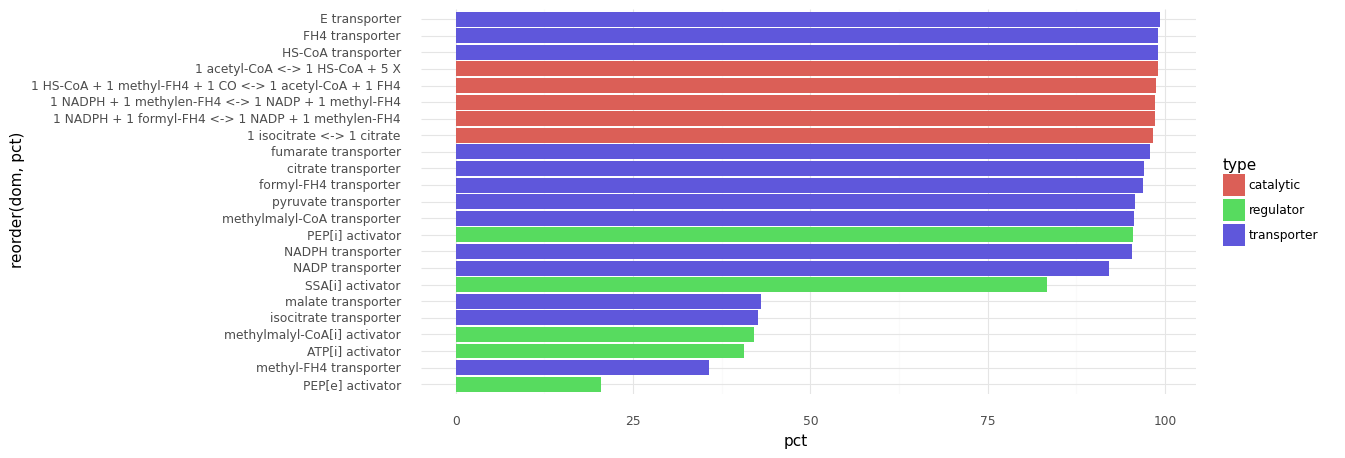

<ggplot: (8770264162752)>

In [91]:
n0_genome = genome_counts.most_common(n=1)[0][0]
n0_i = world.genomes.index(n0_genome)

n0_prots = set(d for d in all_cell_prots[n0_i] if len(d) > 0)
n0_doms = set(dd.strip() for d in n0_prots for dd in d.split("|"))

dom_cnts = {d: 0 for d in n0_doms}
for prots in all_cell_prots:
    for dom in n0_doms:
        if dom_in_proteome(dom=dom, prots=prots):
            dom_cnts[dom] += 1

n = len(all_cell_prots)
df = pd.DataFrame.from_records([{"dom": k, "pct": d / n * 100} for k, d in dom_cnts.items()])
df.loc[:, "type"] = "regulator"
df.loc[["transporter" in d for d in df["dom"]], "type"] = "transporter"
df.loc[["<->" in d for d in df["dom"]], "type"] = "catalytic"

(ggplot(df.sort_values("pct"))
    + geom_col(aes(y="pct", x="reorder(dom, pct)", fill="type"))
    + coord_flip()
    + theme(figure_size=(10, 5)))

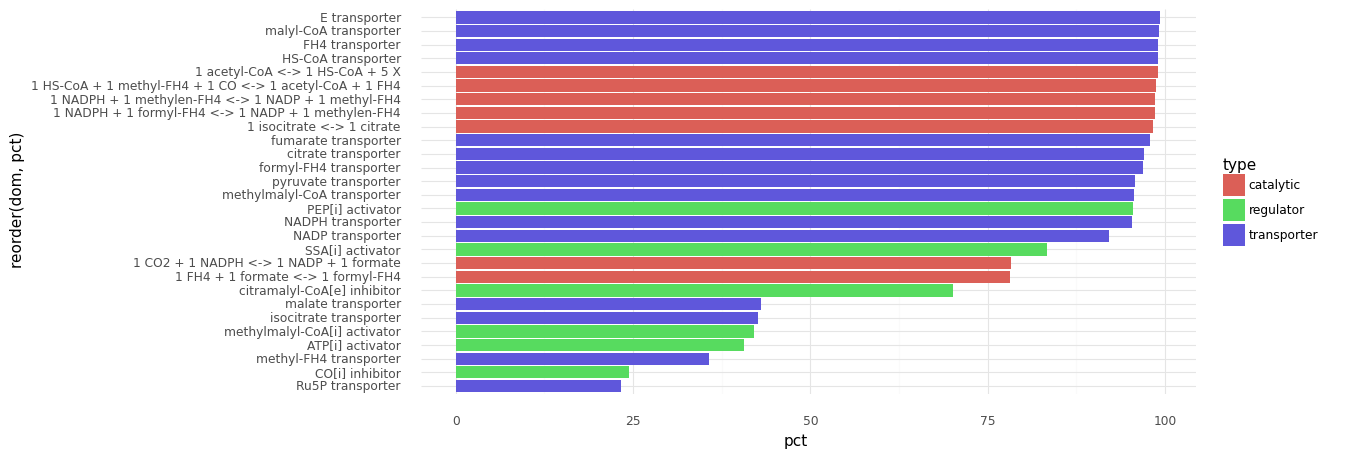

<ggplot: (8770263905653)>

In [93]:
n0_genome = genome_counts.most_common(n=2)[1][0]
n0_i = world.genomes.index(n0_genome)

n0_prots = set(d for d in all_cell_prots[n0_i] if len(d) > 0)
n0_doms = set(dd.strip() for d in n0_prots for dd in d.split("|"))

dom_cnts = {d: 0 for d in n0_doms}
for prots in all_cell_prots:
    for dom in n0_doms:
        if dom_in_proteome(dom=dom, prots=prots):
            dom_cnts[dom] += 1

n = len(all_cell_prots)
df = pd.DataFrame.from_records([{"dom": k, "pct": d / n * 100} for k, d in dom_cnts.items()])
df.loc[:, "type"] = "regulator"
df.loc[["transporter" in d for d in df["dom"]], "type"] = "transporter"
df.loc[["<->" in d for d in df["dom"]], "type"] = "catalytic"

(ggplot(df.sort_values("pct"))
    + geom_col(aes(y="pct", x="reorder(dom, pct)", fill="type"))
    + coord_flip()
    + theme(figure_size=(10, 5)))

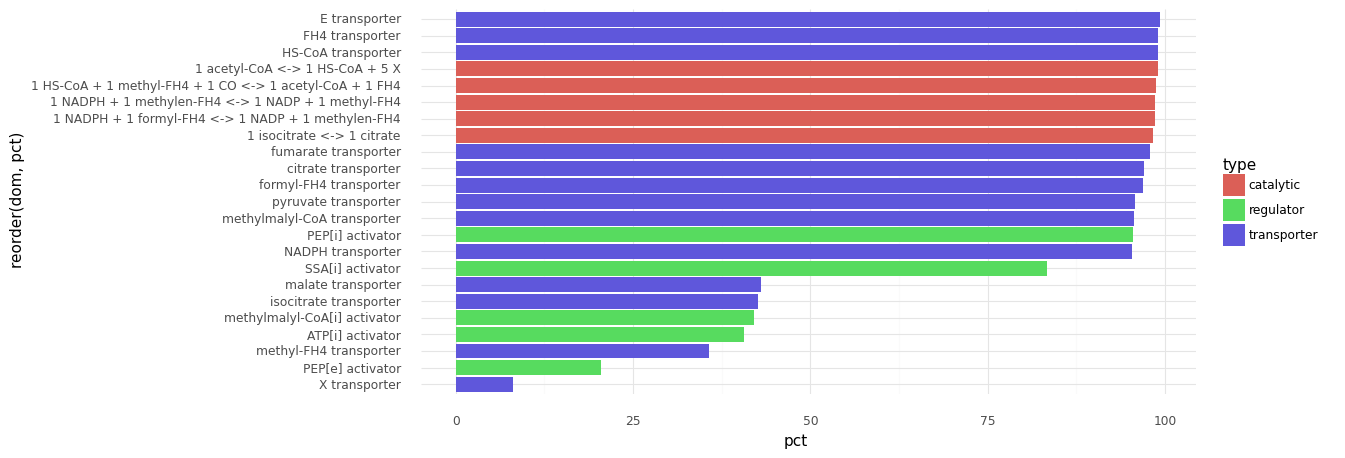

<ggplot: (8770264349252)>

In [94]:
n0_genome = genome_counts.most_common(n=3)[2][0]
n0_i = world.genomes.index(n0_genome)

n0_prots = set(d for d in all_cell_prots[n0_i] if len(d) > 0)
n0_doms = set(dd.strip() for d in n0_prots for dd in d.split("|"))

dom_cnts = {d: 0 for d in n0_doms}
for prots in all_cell_prots:
    for dom in n0_doms:
        if dom_in_proteome(dom=dom, prots=prots):
            dom_cnts[dom] += 1

n = len(all_cell_prots)
df = pd.DataFrame.from_records([{"dom": k, "pct": d / n * 100} for k, d in dom_cnts.items()])
df.loc[:, "type"] = "regulator"
df.loc[["transporter" in d for d in df["dom"]], "type"] = "transporter"
df.loc[["<->" in d for d in df["dom"]], "type"] = "catalytic"

(ggplot(df.sort_values("pct"))
    + geom_col(aes(y="pct", x="reorder(dom, pct)", fill="type"))
    + coord_flip()
    + theme(figure_size=(10, 5)))

In [95]:
# TODO: mit den domain overlaps kann ich mir eine similarity herstellen (k von n domains oder k von n proteins)
#       damit kann ich Zellen einfärben und mir auf Karte anschauen

# die top 3 genomes können alleine gar nicht überleben
# die brauchen eine kleinere subpopulation an Zellen die "1 CO2 + 1 NADPH <-> 1 NADP + 1 CO"
# hat um CO herzustellen (CO diffundiert ja dann überall rum)

# TODO: wie CO verteilt ist könnte ich auch plotten
#       sollte ja hochkonzentriert um diese CO Zellen herum sein

{'1 CO2 + 1 NADPH <-> 1 NADP + 1 CO | 1 HS-CoA + 1 methyl-FH4 + 1 CO <-> 1 acetyl-CoA + 1 FH4',
 '1 CO2 + 1 NADPH <-> 1 NADP + 1 CO | E transporter | 1 NADP + 1 E <-> 1 NADPH',
 '1 CO2 + 1 NADPH <-> 1 NADP + 1 CO | oxalacetate[e] activator',
 '1 HS-CoA + 1 methyl-FH4 + 1 CO <-> 1 acetyl-CoA + 1 FH4',
 '1 HS-CoA + 1 methyl-FH4 + 1 CO <-> 1 acetyl-CoA + 1 FH4 | 1 NADPH + 1 formyl-FH4 <-> 1 NADP + 1 methylen-FH4',
 '1 HS-CoA + 1 methyl-FH4 + 1 CO <-> 1 acetyl-CoA + 1 FH4 | formate transporter',
 '1 HS-CoA + 1 methyl-FH4 + 1 CO <-> 1 acetyl-CoA + 1 FH4 | fumarate transporter',
 '1 NADP + 1 CO <-> 1 CO2 + 1 NADPH',
 '1 citrate <-> 1 isocitrate | 1 HS-CoA + 1 methyl-FH4 + 1 CO <-> 1 acetyl-CoA + 1 FH4',
 '1 isocitrate <-> 1 citrate | 1 HS-CoA + 1 methyl-FH4 + 1 CO <-> 1 acetyl-CoA + 1 FH4',
 'E transporter | 1 NADP + 1 CO <-> 1 CO2 + 1 NADPH',
 'FH4 transporter | 1 HS-CoA + 1 methyl-FH4 + 1 CO <-> 1 acetyl-CoA + 1 FH4',
 'FH4 transporter | 1 HS-CoA + 1 methyl-FH4 + 1 CO <-> 1 acetyl-CoA + 1 